In [15]:
# FFT
# 4096 points FFT
# Average 5
# Overlap 2/3

import numpy as np
import matplotlib.pyplot as plt
import math

# Print_level 3     (0 no print, 1 process, 2 data, 3 plot)
print_level = 2

# Startup
if print_level>0: print('In startup...')

frame_size = 4096   # 定义FFT帧大小
fs = 15360.0    # 采样频率，需要根据实际大小定义
average = 5     # 频谱平均次数
overlap = 2.0/3.0   # FFT时，时域波形重叠度
system_gain = 12.0  # 系统增益（放大倍数）
cutoff = 5.0    # 传感器频率下限为5Hz，上限为6kHz
spectrum_lines = int(frame_size / 2.56)     # 最后取频谱的线数1600

para_harmonic=np.array(['Harmonic 1xRPM', 'Harmonic 2xRPM', 'Harmonic 3xRPM',
                        'Harmonic 4xRPM', 'Harmonic 5xRPM', 'Harmonic 6xRPM',
                        'Harmonic 7xRPM', 'Harmonic 8xRPM', 'Harmonic 9xRPM',
                        'Harmonic 10xRPM'])

para_nonsyn=np.array(['Subsynchronous', 'Nonsyn 1-2xRPM', 'Nonsyn 2-3xRPM',
                      'Nonsyn 3-4xRPM', 'Nonsyn 4-5xRPM', 'Nonsyn 5-6xRPM',
                      'Nonsyn 6-7xRPM', 'Nonsyn 7-8xRPM', 'Nonsyn 8-9xRPM',
                      'Nonsyn 9-10xRPM'])

# Ref Running Speed
spd_ref_rpm = 54000     # 预设转速，单位是（转/分钟）

def calculate_probability_density(wvfm, plt_range=(-5.0, 5.0),bin_width=0.2):
    '''Calculate probability desity function
    '''
    length = len(wvfm)
    wvfm_rms = np.std(wvfm)
    wvfm_pk_max = np.amax(wvfm)
    wvfm_pk_min = np.amin(wvfm)
    wvfm/=wvfm_rms
    
    plt.subplot(221)
    bin_edges=np.arange(plt_range[0]-bin_width/2, plt_range[1]+bin_width, bin_width)
    hist, bin_edges, patches = plt.hist(wvfm, bin_edges, density=True)

    plt.subplot(222)
    x = np.arange(plt_range[0],plt_range[1]+bin_width, bin_width)
    plt.plot(x, hist)

    bin_width = bin_width / 2
    plt.subplot(223)
    bin_edges=np.arange(plt_range[0]-bin_width/2, plt_range[1]+bin_width, bin_width)
    hist, bin_edges, patches = plt.hist(wvfm, bin_edges, density=True)

    plt.subplot(224)
    x = np.arange(plt_range[0],plt_range[1]+bin_width, bin_width)
    plt.plot(x, hist)
        
    plt.show()
    plt.close()

    return hist


def analog_signal_generator(t):
    '''Generate analog signal.

    Waveform Simulation
    '''
    if print_level>0: print('In waveform simulation...')

    trail_spd_hz = 913.27
    waveform = np.zeros_like(t)
    waveform = 0.5680 / 2.0 * np.sin( 2.0 * math.pi * t * 49.94 + 4.0 )
    waveform += 0.2850 / 2.0 * np.sin( 2.0 * math.pi * t * 355.11 + 3.8 )
    waveform += 0.3143 / 2.0 * np.sin( 2.0 * math.pi * t * 358.85 + 2.6 )
    waveform += 6.1974 / 2.0 * np.sin( 2.0 * math.pi * t * trail_spd_hz * 1.0 + 0.25 )
    waveform += 0.7003 / 2.0 * np.sin( 2.0 * math.pi * t * trail_spd_hz * 2.0 + 1.2 )
    waveform += 0.9333 / 2.0 * np.sin( 2.0 * math.pi * t * trail_spd_hz * 3.0 + 0.8 )
    waveform += 0.9028 / 2.0 * np.sin( 2.0 * math.pi * t * trail_spd_hz * 4.0 + 0.6 )
    waveform += 0.2851 / 2.0 * np.sin( 2.0 * math.pi * t * trail_spd_hz * 5.0 + 0.2 )
    waveform += 0.2 * np.random.randn(len(t))

    '''
    trail_spd_hz = 49.94
    waveform = np.zeros_like(t)
    xRPM_num = int(6000/trail_spd_hz)
    theta = np.random.random(xRPM_num) * 2.0 * math.pi
    Amp_1xRPM = 6.1974
    
    for i in range(xRPM_num):
        waveform += Amp_1xRPM / 2.0 / (i+1) * np.sin( 2.0 * math.pi * t * trail_spd_hz * (i+1) + theta[i] )
    waveform += 0.2850 / 2.0 * np.sin( 2.0 * math.pi * t * 355.11 + 3.8 )
    waveform += 0.3143 / 2.0 * np.sin( 2.0 * math.pi * t * 358.85 + 2.6 )
    waveform += 0.2 * np.random.randn(len(t))
    '''
    
    plt.subplot(211)
    plt.title("Waveform Simulation")
    plt.plot(t,waveform)

    plt.subplot(212)
    plt.title("Waveform 1024")
    plt.plot(t[:1024], waveform[:1024])
    plt.tight_layout()
    plt.show()
    plt.close()

    return waveform

def linearRegression(y):
    '''Linear Regression.
    '''
    if print_level>0: print('In linear regression...')

    avg_XY = 0.0
    avg_X = 0.0
    avg_Y = 0.0
    avg_XX = 0.0
    length = len(y)

    for i in range(length):
        avg_XY += i * y[i] / length
        avg_X += i / length
        avg_Y += y[i] / length
        avg_XX += i * i / length
    slope = (avg_XY - avg_X * avg_Y) / (avg_XX - avg_X * avg_X)
    intercept = avg_Y - slope * avg_X;
    if print_level>1: print('slope= %12.5f' %slope, '\tintercept=%12.5f' %intercept)

    for i in range(length):
        y[i] = y[i] - (slope * i + intercept)

    return y

def processing_5_time_FFT(wvfrm, avg=5, frm=frame_size, ovrlp=overlap):
    '''Processing 5 times FFT
    '''
    print('\nProcessing FFT...')

    k = np.arange(frm)
    x_part = np.zeros_like(k, dtype='float')
    flat_window = np.ones_like(k)
    hann_window = 0.5*(1.0-np.cos( 2.0*math.pi*k/float(frm-1)))
    spctrm_avg = np.zeros_like(k, dtype=float)

    wvfrm = wvfrm.astype('float')

    for i in range(0, avg):
        a_start = int( i * frm * (1.0-ovrlp))   # Frame start point
        a_end = a_start + frame_size         # Frame end point (not included)
        if print_level>0:
            print('Processing the FFT, No. ', i+1)
        if print_level>1:
            print('Frame starts from ', a_start, ' to ', a_end-1)

        np.multiply( wvfrm[a_start:a_end], flat_window, x_part) # Take one frame
        x_part=linearRegression(x_part)        # Detrend
        np.multiply( x_part, hann_window, x_part)    # Add Hanning Window

        spctrm = np.fft.fft(x_part)      # FFT
        spctrm = np.abs(spctrm) * 2.0 / frm     # FFT Normalization
        spctrm[0] = 0.0  # Remove DC current

        if print_level>2: spectrum_plot(x_part, spctrm)

        spctrm_avg = ( spctrm_avg * float(i) + spctrm ) / float(i+1)

    # Plot Averaged Spectrum
    spctrm_avg *= 2.0   # Amplitude Correction
    spctrm_avg *= 2.0   # Peak Val to Pk-Pk Val
    if print_level>0:
        print('Print averaged spectrum.')
        spectrum_plot(wvfrm[-frm:], spctrm_avg)

    lines = int(frm/2.56)+1
    return spctrm_avg[:lines]

def find_running_speed_true(pw_spc, spd_ref_line, freq_span=0.025, petal_num=2):
    '''Find true running speed
    '''
    if print_level>0: print('\nFinding live running speed...')

    # 寻找范围，参考转速左右各2.5%，找到最大峰值
    r_start = int(spd_ref_line*(1-freq_span))
    r_end = int(spd_ref_line*(1+freq_span)+1)
    spd_index = r_start + np.argmax(pw_spc[r_start:r_end+1])

    # 峰值左右各取2点，共5点，进行计算
    petal_power_sum = sum(pw_spc[spd_index-petal_num : spd_index+petal_num+1])
    left_petal_ratio = sum(pw_spc[spd_index-petal_num:spd_index]) / petal_power_sum
    right_petal_ratio = sum(pw_spc[spd_index+1:spd_index+petal_num+1]) / petal_power_sum
    petal_ratio_sum = left_petal_ratio + right_petal_ratio
    if print_level>1:
        print('Petal ratio:')
    if print_level>1:
        print('%12.5f, %12.5f' %(left_petal_ratio, right_petal_ratio))

    if petal_ratio_sum<0.33 or petal_ratio_sum>0.52:
        if print_level>0: print('Can\'t verify running speed.')
        return 0.0, 0.0
    else:
        spd_true = 0.0
        for i in range(spd_index-petal_num, spd_index+petal_num+1):
            spd_true += i * pw_spc[i]
        spd_true /= petal_power_sum
        if print_level>1:
            print('True Running Speed is %12.5f lines.' %spd_true)
        Amp_1xRPM_true = np.sqrt(petal_power_sum * 8.0 / 3.0) / 2.0
        if print_level>1:
            print('Amplitude Pk-Pk in 1xRPM is %12.5f Microns.' %digit2micron(Amp_1xRPM_true))

        return spd_true, Amp_1xRPM_true

def calculate_waveform_parameters(wf):
    '''Calculating waveform parameters. 计算波形参数
    '''
    wf_parameters={}
    wf_parameters['wfMaxP'] = {'Dim': True, 'value': np.amax(wf)}   # 最大正峰值
    wf_parameters['wfMinP'] = {'Dim': True, 'value': np.amin(wf)}      # 最大负峰值
    wf_parameters['wfMean'] = {'Dim': True, 'value': np.average(wf)}    # 平均值
    wf_parameters['wfARV'] = {'Dim': True, 'value': np.average(np.abs(wf))}     # 整流平均值
    wf_parameters['wfRMS'] = {'Dim': True, 'value': np.std(wf)}     # 有效均方根值
    wf_parameters['wfSMRA'] = {'Dim': True,
                               'value': np.square(np.average(np.sqrt(np.abs(wf))))} # 计算方根幅值
    wf_parameters['wfFormF'] = {'Dim': False,
                                'value': wf_parameters['wfRMS']['value'] / wf_parameters['wfARV']['value']} # 波形因子
    wf_parameters['wfCrestFpos'] = {'Dim': False,
                                    'value': wf_parameters['wfMaxP']['value'] / wf_parameters['wfRMS']['value']}    # 正峰值因子
    wf_parameters['wfCrestFneg'] = {'Dim': False,
                                'value': wf_parameters['wfMinP']['value'] / wf_parameters['wfRMS']['value']}    # 负峰值因子
    wf_parameters['wfImpulseFpos'] = {'Dim': False,
                                'value': wf_parameters['wfMaxP']['value'] / wf_parameters['wfARV']['value']}        # 正脉冲因子
    wf_parameters['wfImpulseFneg'] = {'Dim': False,
                                'value': wf_parameters['wfMinP']['value'] / wf_parameters['wfARV']['value']}    # 负脉冲因子
    wf_parameters['wfMarginFpos'] = {'Dim': False,
                                'value': wf_parameters['wfMaxP']['value'] / wf_parameters['wfSMRA']['value']}   # 正裕度因子
    wf_parameters['wfMarginFneg'] = {'Dim': False,
                                'value': wf_parameters['wfMinP']['value'] / wf_parameters['wfSMRA']['value']}   # 负裕度因子
    wf_parameters['wfKurtosis'] = {'Dim': False,
                                'value': np.average(pow(wf, 4)) / pow(wf_parameters['wfRMS']['value'], 4)}      # 峭度因子
    wf_parameters['wfSkewness'] = {'Dim': False,
                                'value': np.average(pow(wf, 3)) / pow(wf_parameters['wfRMS']['value'], 3)}  # 偏度因子
    return wf_parameters

def calculate_spectral_parameters(spd, pw_spc, pa_span=0.15, cut=cutoff):
    '''Calculate Spectral Parameters. 计算频谱参数
    '''
    if print_level>0: print('\nCalculating spectral parameters...')

    spc_len=len(pw_spc)

    pa_harmonic_value = np.zeros(10)
    pa_nonsyn_value = np.zeros(10)

    pa_harmonic_span=np.zeros((10,2), dtype='int')
    pa_nonsyn_span=np.zeros((10,2), dtype='int')

    harmonic_number = int(spc_len/spd)
    if harmonic_number > 10: harmonic_number=10
    if print_level>1: print('Harmonic number is ', harmonic_number)

    # Get overall value
    overall_pkpk_span=(0, spc_len-1)
    overall_pkpk_value=calculate_band_energy(pw_spc, overall_pkpk_span)
    overall_pkpk_value=np.sqrt(overall_pkpk_value * 8.0 / 3.0) /2.0

    if print_level>1:
        print('Overall Pk-Pk Value is %10.5f Microns.' %digit2micron(overall_pkpk_value))
        print('Overall Peak Value is %10.5f Microns.' %digit2micron(overall_pkpk_value/2))
        print('Overall RMS Value is %10.5f Microns.' %digit2micron(overall_pkpk_value/2/np.sqrt(2)))

    # Setup parameter spans 计算频段的上下限
    pa_nonsyn_span[0, 0] = int(frame_size*cut/fs+0.5)
    for i in range(harmonic_number):
        pa_nonsyn_span[i,1]=np.round((i+1-pa_span)*spd, 0)
        pa_harmonic_span[i,0]=pa_nonsyn_span[i,1]
        pa_harmonic_span[i,1]=np.round((i+1+pa_span)*spd, 0)
        if i<9: pa_nonsyn_span[i+1,0]=pa_harmonic_span[i,1]
    if pa_harmonic_span[harmonic_number-1,1]>(spc_len-1):
        pa_harmonic_span[harmonic_number-1,1]=(spc_len-1)
        if harmonic_number<10:pa_nonsyn_span[harmonic_number,0]=0
    elif harmonic_number<10:
        pa_nonsyn_span[harmonic_number,1]=np.round((harmonic_number+1-pa_span)*spd, 0)
        if pa_nonsyn_span[harmonic_number,1]>(spc_len-1):
            pa_nonsyn_span[harmonic_number,1]=(spc_len-1)

    for i in range(10):
        if pa_nonsyn_span[i,0] and pa_nonsyn_span[i,1]:
            pa_nonsyn_value[i] = calculate_band_energy(pw_spc, pa_nonsyn_span[i,:])
            pa_nonsyn_value[i] = np.sqrt(pa_nonsyn_value[i] * 8.0 / 3.0) / 2.0
        if pa_harmonic_span[i,0] and pa_harmonic_span[i,1]:
            pa_harmonic_value[i] = calculate_band_energy(pw_spc, pa_harmonic_span[i,:])
            pa_harmonic_value[i] = np.sqrt(pa_harmonic_value[i] * 8.0 / 3.0) / 2.0

    if print_level>1:
        print('\nParameter Name', '\t\tBin Edge', '\tMicrons', '\tDigital')
        for i in range(0,10):
            print(para_nonsyn[i],
                  ': \t%4d %4d' %(pa_nonsyn_span[i,0], pa_nonsyn_span[i,1]),
                  '    %10.5f' %digit2micron(pa_nonsyn_value[i]),
                  '    %6.0f' %pa_nonsyn_value[i])
        for i in range(0,10):
            print(para_harmonic[i],
                  ': \t%4d %4d' %(pa_harmonic_span[i,0],pa_harmonic_span[i,1]),
                  '    %10.5f' %digit2micron(pa_harmonic_value[i]),
                  '    %6.0f' %pa_harmonic_value[i])
    return overall_pkpk_value, pa_nonsyn_value, pa_harmonic_value

def find_true_pkpk(spd, wvfm, frm_size=frame_size):
    '''Find True Peak 寻找真峰峰值

        在1.5个周期内，最大值最小值的差
        移动1个周期，找下一个最大值最小值的差
        比较，保留大的
    '''
    if print_level>0: print('\nFinding True Pk-Pk Value...')

    wvfm_len=len(wvfm)

    sampling_points_in_cycle = int(np.round(frm_size/spd, 0))
    i=0
    j=i+int(sampling_points_in_cycle*1.5)
    true_pkpk_digit=0

    while j<=(wvfm_len-1):
        true_pkpk_digit=max(true_pkpk_digit, np.amax(wvfm[i:j])-np.amin(wvfm[i:j]))
        i+=sampling_points_in_cycle
        j+=sampling_points_in_cycle
    if print_level>1:
        print('True Pk-Pk Value is %10.5f Microns, \t%5d' %(digit2micron(true_pkpk_digit),true_pkpk_digit))

    return true_pkpk_digit

# Functions
def spectrum_plot(waveform, spectrum, fsampling=fs, points=frame_size):
    if print_level>0: print('Plotting spectrum...')
    waveform_t=np.arange(len(waveform)) / fsampling
    frequency_axis=np.arange(len(spectrum)) * fsampling / points

    plt.subplot(211)
    plt.plot(waveform_t,waveform)
    plt.title("Original Waveform")

    plt.subplot(212)
    plt.title("Spectrum")
    yf = spectrum
    lines = int(points/2.56+1)
    plt.plot(frequency_axis[:lines],yf[:lines])

    plt.tight_layout()
    plt.show()
    plt.close()

def analog2digital(waveform_analog, sensor_sensitivity=7.874, hardware_gain=system_gain,
                   adc_resolution_bit=15, ref_voltage=3300.0):
    '''Digitalize analog signal.
    '''
    if print_level>0: print('Digitalizing analog signal...')

    waveform_analog *= sensor_sensitivity
    waveform_analog *= hardware_gain
    waveform_analog *= 2**(adc_resolution_bit) / ref_voltage
    waveform_analog += 2**(adc_resolution_bit-1)

    waveform_analog += 0.5
    waveform_adc_output = waveform_analog.astype('int')

    return waveform_adc_output

def digit2micron(x, sensor_sensitivity=7.874, hardware_gain=system_gain,
                   adc_resolution_bit=15, ref_voltage=3300.0):

    x *= ref_voltage/2**(adc_resolution_bit)
    x /= hardware_gain
    x /= sensor_sensitivity
    
    return x

def calculate_band_energy(pw_spc, span):
    energy = 0.5 * pw_spc[span[0]]
    energy += sum(pw_spc[span[0]+1:span[1]])
    energy += 0.5 * pw_spc[span[1]]
    return energy


In startup...


In [16]:
'''XG9900 Algorithm

Date: 2020-10-30
Version: 0.1
'''
# Setup
waveform_length =frame_size+int((average-1)*frame_size*(1.0-overlap))     # Calculate waveform length 计算波形长度，够5次FFT
t = np.arange(0, waveform_length/fs, 1/fs)  # 时间坐标，以 fs 为采样频率，持续时间在 0~waveform_length/fs 之间

print('frame_size=',frame_size)
print('fs=',fs)
print('waveform_length=',waveform_length)
print(t)

y_average = np.zeros_like(frame_size)   # 频谱平均存放
power_spec=np.zeros(spectrum_lines+1)   # 定义功率谱，是普通频谱的平方。考虑有0点，所以加1

para_harmonic_span=np.zeros((10,2), dtype='int')    # 定义频谱参数计算时，在频谱中谱线的上下限
para_nonsyn_span=np.zeros((10,2), dtype='int')      # 定义频谱参数计算时，在频谱中谱线的上下限

frame_size= 4096
fs= 15360.0
waveform_length= 9557
[0.00000000e+00 6.51041667e-05 1.30208333e-04 ... 6.22005208e-01
 6.22070312e-01 6.22135417e-01]


In [17]:
test_arange = np.arange(0, 10, 2)
print(test_arange)

[0 2 4 6 8]


In waveform simulation...


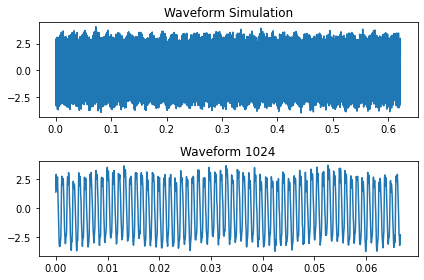

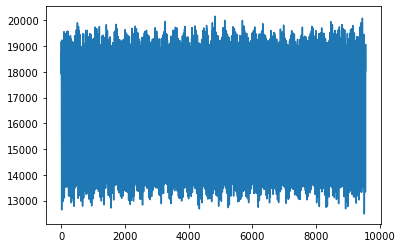

In [18]:
# Generate a waveform
x_analog = analog_signal_generator(t)   # 生成模拟波形
#x_digital = analog2digital(x_analog)    # x_digital is just like the output of ADC 模拟波形数字化，模拟ADC

#file_open=open("source.txt",'w')
#data=','.join(map(str, x_digital))
#file_open.write(data)

x_digital = np.loadtxt('source_fixed.txt', delimiter=',')

plt.plot(np.arange(0, x_digital.size),x_digital)
plt.show()

Linear Regression on the whole waveform...
9557
17962.0
17962.0


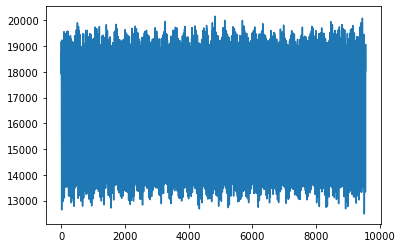

17962.0 18044.0
In linear regression...
slope=      0.00140 	intercept= 16374.24775
1587.7522533222036 1656.4053275087354


In [19]:
# Turn to float and detrend
if print_level>0: print('Linear Regression on the whole waveform...')

x = x_digital.astype('float')   # Turn to float 数字量从整数转为浮点数

print(x.size)
print(x[0])
print(x_digital[0])

plt.plot(np.arange(0, x.size),x)
plt.show()

print(x[0], x[-1]);

x = linearRegression(x)  # Detrend 消除趋势项，采用最小二乘法

print(x[0], x[-1]);

In [30]:
# Calculate waveform parameters 计算波形参数
waveform_parameters = calculate_waveform_parameters(x)  # 调用波形参数计算模块

# Print waveform parameters. Dimensional parameters need transform, while no need for the dimensionless
print('\nPrint waveform parameters...')
for key, value in waveform_parameters.items():
    if value['Dim']: print(key, '=%12.5f\t%d\t%12.5f'%(digit2micron(value['value']), int(round(value['value'],0)), value['value']))
    else: print(key,'=%12.5f\t%d'%(value['value'], int(round(value['value']*2**10,0))))


Print waveform parameters...
wfMaxP =     2.85899	2682	  2682.40812
wfMinP =    -1.11335	-1045	 -1044.58909
wfMean =     0.00076	1	     0.71077
wfARV =     0.00197	2	     1.84699
wfRMS =     0.04600	43	    43.16111
wfSMRA =     0.00095	1	     0.89277
wfFormF =    23.36841	23929
wfCrestFpos =    62.14873	63640
wfCrestFneg =   -24.20209	-24783
wfImpulseFpos =  1452.31709	1487173
wfImpulseFneg =  -565.56442	-579138
wfMarginFpos =  3004.60443	3076715
wfMarginFneg = -1170.05946	-1198141
wfKurtosis =  2750.22327	2816229
wfSkewness =    47.87567	49025



Processing FFT...
Processing the FFT, No.  1
Frame starts from  0  to  4095
In linear regression...
slope=     -0.00166 	intercept=     0.66917
Processing the FFT, No.  2
Frame starts from  1365  to  5460
In linear regression...
slope=      0.00413 	intercept=     0.22018
Processing the FFT, No.  3
Frame starts from  2730  to  6825
In linear regression...
slope=     -0.00368 	intercept=     3.10552
Processing the FFT, No.  4
Frame starts from  4096  to  8191
In linear regression...
slope=     -0.01146 	intercept=    23.32359
Processing the FFT, No.  5
Frame starts from  5461  to  9556
In linear regression...
slope=      0.00766 	intercept=   -21.35247
Print averaged spectrum.
Plotting spectrum...


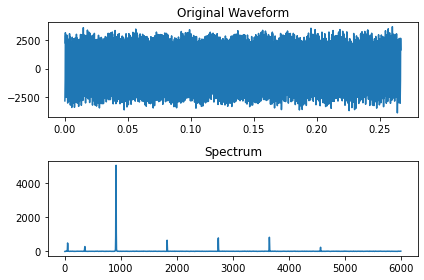

In [21]:
# FFT 5 times
spectrum = processing_5_time_FFT(x)     # 进行FFT计算，5次平均
low_cut = int(frame_size * cutoff / fs + 1)     # 将传感器频率下限以下的值置零
for i in range(low_cut): spectrum[i] = 0.0     # Remove data below 5 Hz

In [22]:
# Calculate Overall 计算位移通频值（峰峰值），频谱的平方和，经过修正
dsp_Overall = np.sum(np.square(spectrum))   # 中间过程
dsp_Overall = np.sqrt(dsp_Overall * 8.0 / 3.0) /2   # 修正
dsp_Overall_um = digit2micron(dsp_Overall)

print(dsp_Overall)
print(dsp_Overall_um)

6022.564989618065
6.419021696149195


In [23]:
# 计算速度通频值（有效均方根值），频谱的平方和，经过修正
spectrum_vel = spectrum * np.arange(len(spectrum)) * 2.0 * np.pi * fs / frame_size # 将位移谱转为速度谱，谱上每一点乘以2*PI*该点频率
vel_Overall = np.sum(np.square(spectrum_vel))   # 中间过程
vel_Overall = np.sqrt(vel_Overall * 8.0 / 3.0) /2 /2 /np.sqrt(2.0)      # 修正，并转为有效均方根值
vel_Overall = vel_Overall / 1000    # 单位转换
vel_Overall_mmps = digit2micron(vel_Overall)



In [24]:
# 计算加速度通频值（有效均方根值），频谱的平方和，经过修正
spectrum_acc = spectrum_vel * np.arange(len(spectrum)) * 2.0 * np.pi * fs / frame_size # 将速度谱转为加速度谱，谱上每一点乘以2*PI*该点频率
acc_Overall = np.sum(np.square(spectrum_acc))   # 中间过程
acc_Overall = np.sqrt(acc_Overall * 8.0 / 3.0) /2 /2 /np.sqrt(2.0)  # 修正，并转为有效均方根值
acc_Overall = acc_Overall / 1000 / 1000 / 9.81  # 单位转换
acc_Overall_gs = digit2micron(acc_Overall)

print('\nACC Peak Total \t%10.3f G-s\t%10.2f' %(acc_Overall_gs, acc_Overall))
print('VEL Peak Total \t%10.3f mm/Sec\t%10.2f' %(vel_Overall_mmps, vel_Overall))
print('DSP PkPk Total \t%10.3f Micons\t%10.2f' %(dsp_Overall_um, dsp_Overall))
    



ACC Peak Total 	    25.339 G-s	  23773.71
VEL Peak Total 	    16.508 mm/Sec	  15488.25
DSP PkPk Total 	     6.419 Micons	   6022.56


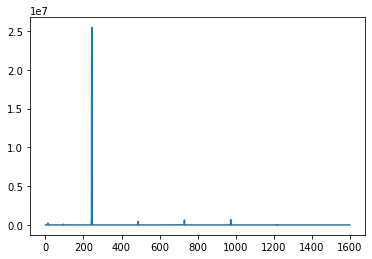

In [25]:
# Turn to Power spectrum 转为功率谱
power_spec = np.square(spectrum)

plt.plot(np.arange(0, power_spec.size), power_spec)
plt.show()

In [26]:
# Searching true runnning speed 确定真实转速
spd_ref_hz = spd_ref_rpm / 60.0     # 参考转速，单位赫兹
spd_ref_line = spd_ref_hz * frame_size / fs     # 参考转速，在频谱中的线数
spd_true_line = 0.0

spd_true_line, Amplitude_1xRPM_true = find_running_speed_true(power_spec, spd_ref_line)     # 调用模块，返回真实转速（线数）
spd_true_hz = spd_true_line * fs / frame_size   # 真实转速，单位赫兹
spd_true_rpm = spd_true_hz * 60     # 真实转速，单位（转/分钟）

if print_level>1:
    print('\n\t\t\t\tLine\t\tHz\t\tRPM')
    print('Running Speed Reference\t%12.2f\t%12.2f\t%12.1f' %(spd_ref_line, spd_ref_hz, spd_ref_rpm))
    print('Running Speed True\t%12.2f\t%12.2f\t%12.1f' %(spd_true_line, spd_true_hz, spd_true_rpm))




Finding live running speed...
Petal ratio:
     0.47030,      0.02471
True Running Speed is    243.53991 lines.
Amplitude Pk-Pk in 1xRPM is      6.18332 Microns.

				Line		Hz		RPM
Running Speed Reference	      240.00	      900.00	     54000.0
Running Speed True	      243.54	      913.27	     54796.5



Calculating spectral parameters...
Harmonic number is  6
Overall Pk-Pk Value is    6.41901 Microns.
Overall Peak Value is    3.20950 Microns.
Overall RMS Value is    2.26946 Microns.

Parameter Name 		Bin Edge 	Microns 	Digital
Subsynchronous : 	   1  207        0.71069        667
Nonsyn 1-2xRPM : 	 280  451        0.15361        144
Nonsyn 2-3xRPM : 	 524  694        0.15360        144
Nonsyn 3-4xRPM : 	 767  938        0.14964        140
Nonsyn 4-5xRPM : 	1011 1181        0.14730        138
Nonsyn 5-6xRPM : 	1254 1425        0.15448        145
Nonsyn 6-7xRPM : 	1498 1600        0.11843        111
Nonsyn 7-8xRPM : 	   0    0        0.00000          0
Nonsyn 8-9xRPM : 	   0    0        0.00000          0
Nonsyn 9-10xRPM : 	   0    0        0.00000          0
Harmonic 1xRPM : 	 207  280        6.18546       5803
Harmonic 2xRPM : 	 451  524        0.71222        668
Harmonic 3xRPM : 	 694  767        0.93919        881
Harmonic 4xRPM : 	 938 1011        0.90627        850
Harmonic 5xRPM

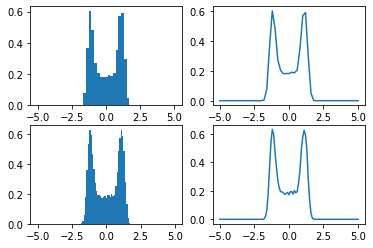


 [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.0020938  0.01884422 0.05967337 0.180067
 0.36222781 0.5391541  0.63232831 0.59673367 0.46587102 0.36536851
 0.27324121 0.22089615 0.19472362 0.19262982 0.18530151 0.1758794
 0.1811139  0.18948911 0.17273869 0.19367672 0.19577052 0.1779732
 0.20205193 0.18634841 0.19577052 0.25649079 0.34547739 0.49204355
 0.57893635 0.6270938  0.59149916 0.48576214 0.28161642 0.13190955
 0.04082915 0.00732831 0.0010469  0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.       

In [14]:
# If speed is verified, calculate spectral parameters 如果能确定真实转速，计算频谱参数
if spd_true_line > 0.0:
    overall_pkpk, para_nonsyn_value, para_harmonic_value = calculate_spectral_parameters(spd_true_line, power_spec) # 计算频谱参数
    true_pkpk_digit = find_true_pkpk(spd_true_line, x) # 真峰峰值

    int_cycle_wvfm_len = int(int(waveform_length*spd_true_hz/fs)*fs/spd_true_hz)  # 在时域波形中，取完整周期的最大整数倍
    hist = calculate_probability_density(x[:int_cycle_wvfm_len])  # 计算分布，需要再考虑一下这里，再讨论
    print('\n', hist)
    print('int cycle wvfm len = ', int_cycle_wvfm_len)